# San Francisco Parking Exploratory Data Analysis
this notebook is for the in depth analyis of the San Francisco Parking Ticket data. The main goal of this will be to answer four questions. 

1. Can we identify streets that are less likely for enforcement officer to travel through, when looking fo residential overtime tickets?

2. How long can we expect to park before we have to move our car?

3. Which hour of street cleaning is most effective at getting people ticketed?

4. Does less frequent street cleaning get mroe tickets per sweep?




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import datetime as dt
import time
from scipy import stats
import geopandas as gpd
import folium
import sqlite3
import seaborn as sns
import statsmodels.formula as sm
%matplotlib inline

/home/colin/.local/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
def result_query(querystring):
    resultdf = pd.read_sql(sql= querystring, con = conn)
    
    return resultdf

In [3]:
raw_folder = '/home/colin/Desktop/SF_Parking/data/raw/'
proc_folder = '/home/colin/Desktop/SF_Parking/data/processed/'

In [5]:
conn = sqlite3.connect(proc_folder + 'SF_Parking.db')
c = conn.cursor()
tables = result_query("SELECT name FROM sqlite_master where type = 'table'")
tables

,name
0,raw_ticket_data
1,raw_address_data
2,single_address
3,ticket_data
4,address_data
5,street_sweep_data
6,street_volume_data


# Theory
I have a theory that parking enforcement officers  don't like busy streets when giving out 'Residential Overtime' tickets. It generally takes more time to mark it and then have to come back later, and they would most likely try to avoid them altogether. Let's see if that has any merrit. 

In [6]:
#Lets categorize addresses by our street volume 
streets = result_query("Select distinct t2.lineid, nhood, distance, total_ea, vvol_busea, speed_ea, count(*) total_tickets "
                       'from ticket_data t1 join address_data t2 on t1.address = t2.address ' 
                       ' join street_volume_data t3 on t2.lineid = t3.lineid '
                       " Where ViolationDesc = 'RES/OT' group by t2.lineid")
c.execute('Select Max(TickIssueDate), Min(TickIssueDate) from ticket_data')
totaldays = c.fetchone()
maxdate = time.strptime( totaldays[0], '%Y-%m-%d %H:%M:%S')
mindate = time.strptime( totaldays[1], '%Y-%m-%d %H:%M:%S')
totaldays = (time.mktime(maxdate) - time.mktime(mindate)) / (60*60*24)
totalyears = totaldays /365

In [7]:
#to avoid any problems log transforming, we'll add 1 to all street volume
streets['total_ea'] = streets['total_ea'] + 1

/home/colin/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 0, 'Total Tickets')

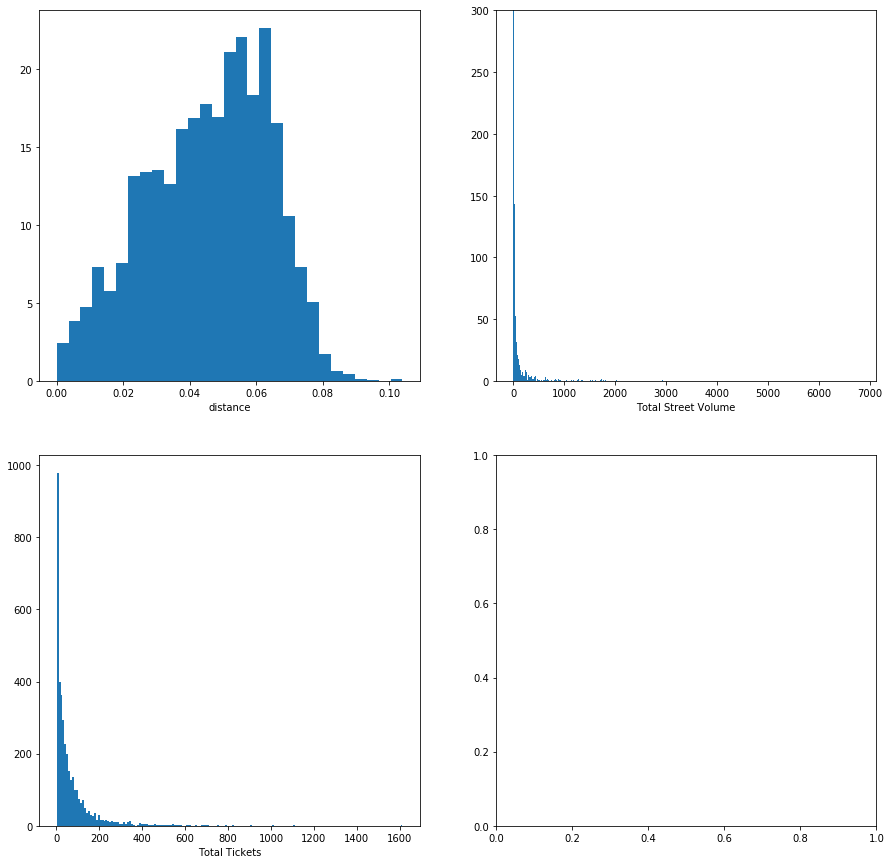

In [8]:
import matplotlib.pyplot as plt 
fig, axplots = plt.subplots(2,2, figsize = (15, 15))

axplots[0,0].hist(streets.distance, bins = 'auto', normed = True)
axplots[0,0].set_xlabel('distance')

axplots[0,1].hist(streets.total_ea, bins = 'auto')
axplots[0,1].set_xlabel('Total Street Volume')
axplots[0,1].set_ylim(0,300)

axplots[1,0].hist(streets.total_tickets, bins = 'auto' )
axplots[1,0].set_xlabel('Total Tickets')

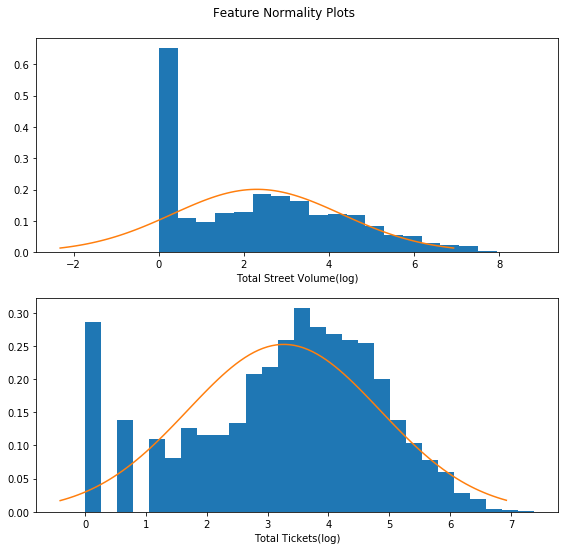

In [9]:
#Lets Log Transform a few 
from scipy.stats import norm

fig, axplots = plt.subplots(2, figsize = (8, 8))
log_volume = np.log(streets['total_ea'])
log_tickets = np.log(streets['total_tickets'])
vol_mean = log_volume.mean()
tick_mean = log_tickets.mean()
vol_std = log_volume.std()
tick_std = log_tickets.std()
vol_normals = norm(loc = vol_mean, scale = vol_std)
vol = np.linspace(vol_normals.ppf(0.01), 
                        vol_normals.ppf(0.99), 100)

tick_normals = norm(loc = tick_mean, scale = tick_std)
ticks = np.linspace(tick_normals.ppf(0.01), 
                        vol_normals.ppf(0.99), 
                        100)


axplots[0].hist(log_volume, bins = 'auto', density = True)
axplots[0].set_xlabel('Total Street Volume(log)')
axplots[0].plot(vol, vol_normals.pdf(vol))

axplots[1].hist(np.log(streets.total_tickets), bins = 'auto', density = True )
axplots[1].set_xlabel('Total Tickets(log)')
axplots[1].plot(ticks, tick_normals.pdf(ticks))

fig.suptitle('Feature Normality Plots')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [10]:
#'Zero' volume streets make the fit more skewed on the left side
streets.shape

(3820, 7)

Text(0.5, 1.0, 'Cumulative Distribution of Street Volume')

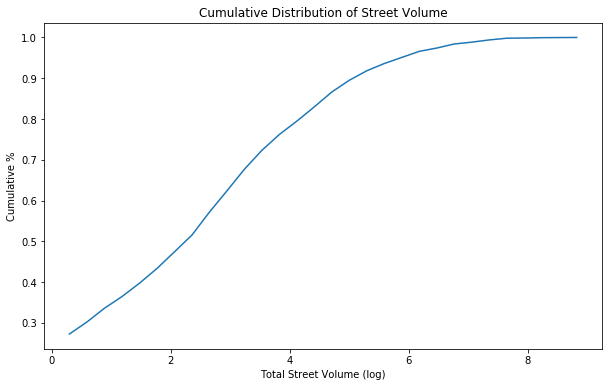

In [11]:
#Lets look at the percentiles of streetvolume
plt.figure(figsize = (10,6))
counts, bin_edges = np.histogram(np.log(streets['total_ea']), bins=30, density=True)
cdf = np.cumsum (counts)
plt.plot(bin_edges[1:], cdf/cdf[-1])
plt.xlabel('Total Street Volume (log)')
plt.ylabel('Cumulative %')
plt.title('Cumulative Distribution of Street Volume')




In [12]:
for q in [25, 50, 75, 100]:
    print ("{}%% percentile: {}".format (q, np.percentile(streets['total_ea'], q)))

25%% percentile: 1.1350025
50%% percentile: 9.880935
75%% percentile: 42.261779999999995
100%% percentile: 6780.86341


Text(0.5, 1.0, 'Scatter Plot of Street Volume vs. Total Tickets')

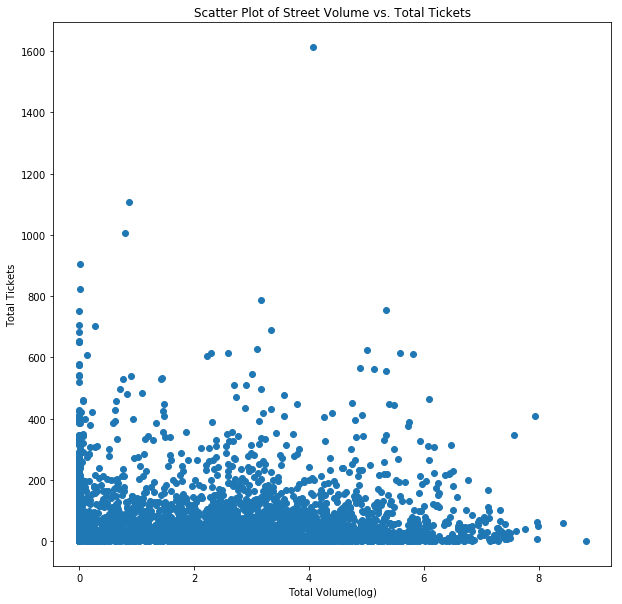

In [13]:
# Lets scatter volume against total tickets

plt.figure(figsize = (10, 10))
plt.scatter(x = np.log(streets['total_ea']), y = streets['total_tickets'])
plt.xlabel('Total Volume(log)')
plt.ylabel('Total Tickets')
plt.title('Scatter Plot of Street Volume vs. Total Tickets')

In [18]:
streets

,lineid,nhood,distance,total_ea,vvol_busea,speed_ea,total_tickets,tickpermile
0,28122.0,Visitacion Valley,0.096445,43.69778,0.00,16.66667,1,4.778568
1,28409.0,Oceanview/Merced/Ingleside,0.090022,73.56350,12.00,19.44440,125,639.936883
2,29028.0,Bayview Hunters Point,0.085618,5.10316,0.00,16.66667,3,16.148480
3,29078.0,Portola,0.086457,1.00000,0.00,16.66667,4,21.322438
4,29152.0,Financial District/South Beach,0.070410,1034.20675,45.18,16.23133,52,340.362165
5,29231.0,Bayview Hunters Point,0.087896,36.54781,0.00,19.44443,1,5.243313
6,29575.0,Bernal Heights,0.073749,9.00086,0.00,16.66667,3,18.747345
7,29593.0,Bernal Heights,0.073290,16.48806,0.00,16.66667,2,12.576597
8,29599.0,Bernal Heights,0.072633,1.00000,0.00,16.66667,2,12.690303
9,29769.0,Portola,0.081820,5.24235,0.00,16.66667,1,5.632702


Text(0.5, 1.0, 'Scatter Plot of Total Street Volume vs. Total Tickers per Mile per Year')

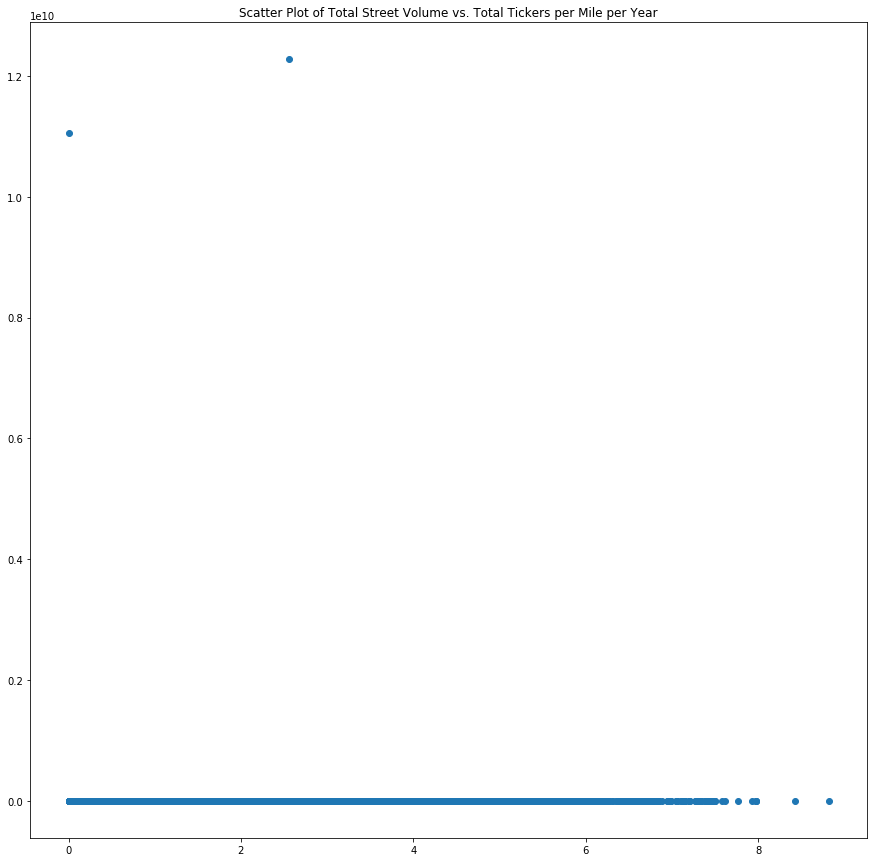

In [14]:
# Lets scatter street volume against volume over distance and convert to a per year basis ('Tickets per mile')
nhoodcolordict = {}
streets['tickpermile'] = streets['total_tickets'] / (streets['distance']) / totalyears
plt.figure(figsize = (15, 15))
plt.scatter(x = np.log(streets['total_ea']), y = streets['tickpermile'])
plt.title('Scatter Plot of Total Street Volume vs. Total Tickers per Mile per Year')

Only the higher volume streets get any bus volume, and they all seem to be lower tickets per mile. 

In [14]:
#Lets split into two populations based on their street volume
df_lowvol = streets[streets.total_ea <=  np.percentile(streets['total_ea'], 50)]
df_highvol = streets[streets.total_ea > np.percentile(streets['total_ea'], 50)]


In [15]:
df_lowvol.describe()

,lineid,distance,total_ea,vvol_busea,speed_ea,total_tickets,tickpermile
count,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000
mean,43944.855352,0.079947,2.536608,0.049295,15.371281,79.898695,523.494047
std,6534.238873,0.042415,2.286282,0.539121,4.250255,110.532364,821.829572
min,29028.000000,0.010000,1.000000,0.000000,11.111110,1.000000,2.710980
25%,39252.000000,0.050000,1.000000,0.000000,13.888890,16.000000,113.444103
50%,43937.000000,0.070000,1.144690,0.000000,16.666670,42.000000,288.041667
75%,48180.500000,0.100000,3.467260,0.000000,16.666670,99.000000,614.488890
max,57759.000000,0.800300,9.654470,6.400000,99.000010,1160.000000,12766.006699


In [16]:
df_highvol.describe()

,lineid,distance,total_ea,vvol_busea,speed_ea,total_tickets,tickpermile
count,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000
mean,43686.008877,0.074469,148.201204,6.489869,15.868325,67.780157,541.554072
std,5434.167564,0.047997,347.073174,10.843618,2.990344,96.196079,1219.498735
min,28122.000000,0.004820,9.661200,0.000000,8.866510,1.000000,1.920278
25%,40581.500000,0.050000,18.846410,0.000000,13.888890,11.000000,81.931852
50%,44218.000000,0.070000,41.405820,0.000000,16.666160,36.000000,248.868001
75%,47118.000000,0.090000,116.580100,12.000000,16.666670,82.000000,562.684867
max,57758.000000,0.690000,6780.863410,135.000000,54.999940,952.000000,32987.344482


Text(0, 0.5, 'Tickets per Mile (log)')

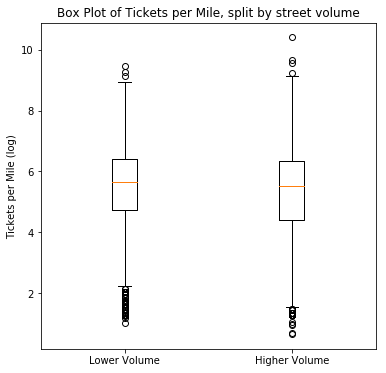

In [17]:
plt.figure(figsize = (6,6))
tickets = [np.log(df_lowvol['tickpermile']),  np.log(df_highvol['tickpermile'])]
plt.boxplot(tickets)
plt.title('Box Plot of Tickets per Mile, split by street volume')
plt.xticks(np.arange(1,3), labels = ('Lower Volume', 'Higher Volume'))
plt.ylabel('Tickets per Mile (log)')

Difference looks pretty insignificant, lets run a t-test. 

In [18]:
print(stats.ttest_ind(df_lowvol['tickpermile'], df_highvol['tickpermile'], equal_var = False))

Ttest_indResult(statistic=-0.5374233419811891, pvalue=0.5910108627225596)


We can not reject the null hypothesis that they have the the same mean. 

In [19]:
df_lowvol['tickpermile'].mean() / df_highvol['tickpermile'].mean()

0.9666514847217277

Looks opposite my original hypotheses. Streets with lower volume tend to get less tickets per limear mile. 

In this case, it may be wise to use the central limit theorem, because you will not have the availablility of streets at your fingertips when finding a parking spot. Let's assume you can pick from 20 different blockss 

In [20]:
#since we have such a high variation, lets use the central limit theorem to estimate the means 
#of four categories of street volume
#Lets use a 3 way split and look at the means
df_1 = streets[streets.total_ea <=  np.percentile(streets['total_ea'], 25)]
df_2 = streets[(streets.total_ea <= np.percentile(streets['total_ea'], 50)) & (streets.total_ea >  np.percentile(streets['total_ea'], 25))]
df_3 = streets[(streets.total_ea <= np.percentile(streets['total_ea'], 75)) & (streets.total_ea >  np.percentile(streets['total_ea'], 50))]
df_4 = streets[streets.total_ea > np.percentile(streets['total_ea'], 75)]

np.random.seed(1)
sample_1 = []
sample_2= []
sample_3 = []
sample_4 = []
for i in np.arange(1,1000):
    sample_1.append(df_1['tickpermile'].sample(n = 20).median())
    sample_2.append(df_2['tickpermile'].sample(n = 20).median())
    sample_3.append(df_3['tickpermile'].sample(n = 20).median())
    sample_4.append(df_4['tickpermile'].sample(n = 20).median())


In [21]:
sample_1 = np.array(sample_1)
sample_2 = np.array(sample_2)
sample_3 = np.array(sample_3)
sample_4 = np.array(sample_4)
total_samples = [sample_1, sample_2, sample_3, sample_4]

normals = {}

x = {}

for i in np.arange(0,4):
    df = total_samples[i]
    mean = df.mean()
    std = df.std()
    normals[i] = norm(loc = mean, scale = std)
    
    x[i] = np.linspace(normals[i].ppf(0.01), 
                        normals[i].ppf(0.99), 
                        100)

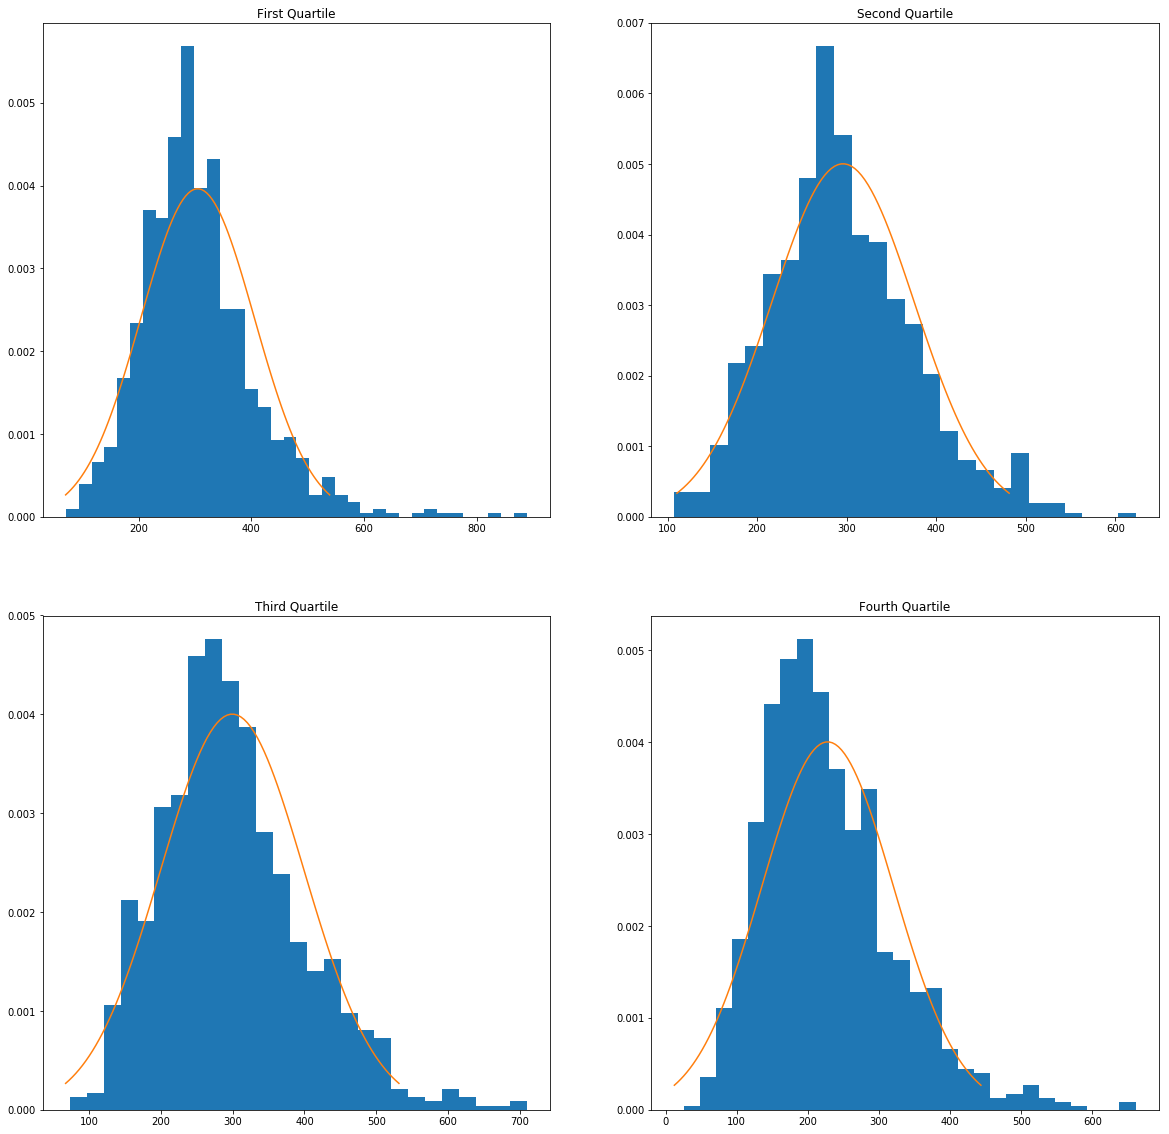

In [22]:
f, axarr = plt.subplots(2,2, figsize = (20,20))

axarr[0,0].hist(sample_1, density = True, bins = 'auto')
axarr[0, 0].plot(x[0], normals[0].pdf(x[0]))
axarr[0,0].set_title('First Quartile')

axarr[0,1].hist(sample_2, density = True, bins = 'auto')
axarr[0,1].plot(x[1], normals[1].pdf(x[1]))
axarr[0,1].set_title('Second Quartile')

axarr[1,0].hist(sample_3, density = True, bins = 'auto')
axarr[1,0].plot(x[2], normals[2].pdf(x[2]))
axarr[1,0].set_title('Third Quartile')

axarr[1,1].hist(sample_4, density = True, bins = 'auto')
axarr[1,1].plot(x[3], normals[2].pdf(x[2]))
axarr[1,1].set_title('Fourth Quartile')

plt.show()

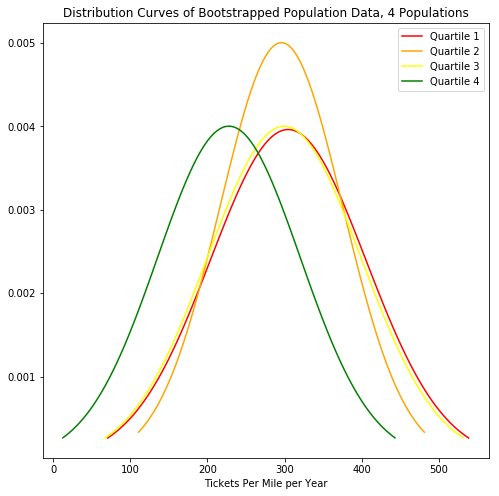

In [23]:
plt.figure(figsize = (8, 8))
plt.plot(x[0], normals[0].pdf(x[0]), color = 'red', label = 'Quartile 1')
plt.plot(x[1], normals[1].pdf(x[1]), color = 'orange', label = 'Quartile 2')
plt.plot(x[2], normals[2].pdf(x[2]), color = 'yellow', label = 'Quartile 3')
plt.plot(x[3], normals[2].pdf(x[2]), color = 'green', label = 'Quartile 4')
plt.title('Distribution Curves of Bootstrapped Population Data, 4 Populations', loc = 'center')
plt.xlabel('Tickets Per Mile per Year')
plt.legend( loc = 0)
plt.show()

The higest volume streets seems to be proving the point. 

Text(0.5, 0, 'Tickets per mile per year')

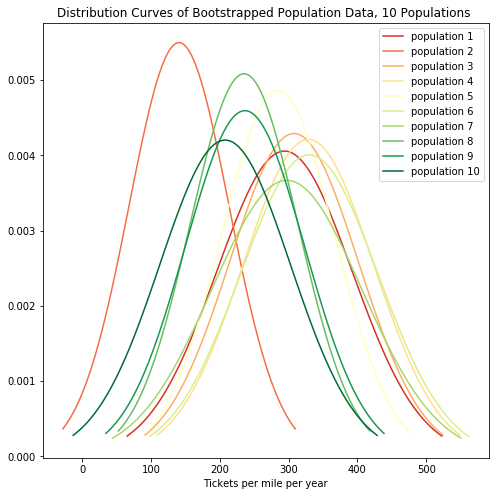

In [24]:
#Let's try to get a little more granular
plt.figure(figsize = (8, 8))
means = {}
stds = {}
for i in np.arange(1,11):
    if i == 1:
        df = streets[streets.total_ea <=  np.percentile(streets['total_ea'], i*10)]
    else:
        df = streets[(streets.total_ea <=  np.percentile(streets['total_ea'], i*10)) & (streets.total_ea >  np.percentile(streets['total_ea'], (i-1)*10))]
        
    sample = []
    for j in np.arange(1,1000):
        sample.append(df['tickpermile'].sample(n = 20, replace = True).median())
        
    sample = np.array(sample)
        
    means[i] = sample.mean()
    stds[i] = sample.std()
    normals = norm(loc = means[i], scale = stds[i])
    
    x = np.linspace(normals.ppf(0.01), 
                        normals.ppf(0.99), 
                        100)
    labelstr = 'population ' + str(i)
    plt.plot(x, normals.pdf(x), label = labelstr, color =  plt.cm.RdYlGn(i/10))
plt.legend( loc = 0)
plt.title('Distribution Curves of Bootstrapped Population Data, 10 Populations ')
plt.xlabel('Tickets per mile per year')

Now we are seeing that the top 10% may have less than in the middle, so its only the highest volume streets that may have an effect. 

In [25]:
#since so many have the same value, we should probably filter the group on a sorted index so the sample sizes are all the same 
streets.sort_values(by = 'total_ea', inplace = True)


Text(0.5, 0, 'Tickets per mile per year')

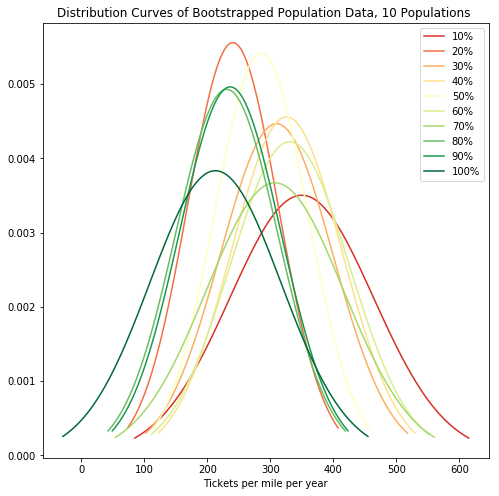

In [26]:
plt.figure(figsize = (8, 8))
means = {}
stds = {}
totalsize = streets.shape[0]
for i in np.arange(1,11):
    if i == 1:
        df = streets[0:int(totalsize * .1)]
    else:
        df = streets[((i-1)/10 * totalsize).astype(int): (((i)/10) * totalsize).astype(int)]

    sample = []
    for j in np.arange(1,1000):
        sample.append(df['tickpermile'].sample(n = 20).median())
        
    sample = np.array(sample)
        
    means[i] = sample.mean()
    stds[i] = sample.std()
    normals = norm(loc = means[i], scale = stds[i])
    
    x = np.linspace(normals.ppf(0.01), 
                        normals.ppf(0.99), 
                        100)
    labelstr = str(i * 10) + '%'
    plt.plot(x, normals.pdf(x), label = labelstr, color =  plt.cm.RdYlGn(i/10))
plt.legend( loc = 0)
plt.title('Distribution Curves of Bootstrapped Population Data, 10 Populations ')
plt.xlabel('Tickets per mile per year')

Were seeing the highest of volume actually may have a correlation with less tickets. 

In [27]:
means[10] / means[5]

0.7460666742461928

Text(0.5, 0, 'Tickets per mile per year')

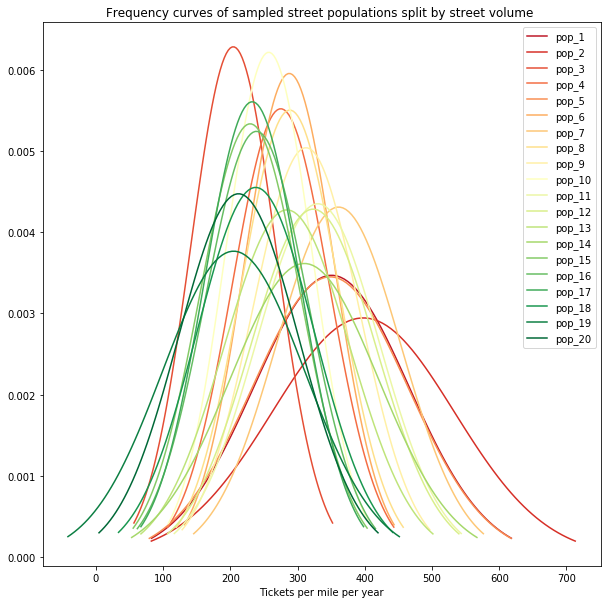

In [28]:
plt.figure(figsize = (10, 10))
means = {}
stds = {}

for i in np.arange(1,21):
    if i == 1:
        df = streets[0:int(totalsize * .1)]
    else:
        df = streets[((i-1)/20 * totalsize).astype(int): (((i)/20) * totalsize).astype(int)]
              
    sample = []
    for j in np.arange(1,1000):
        sample.append(df['tickpermile'].sample(n = 20).median())
        
    sample = np.array(sample)
        
    means[i] = sample.mean()
    stds[i] = sample.std()
    normals = norm(loc = means[i], scale = stds[i])
    
    x = np.linspace(normals.ppf(0.01), 
                        normals.ppf(0.99), 
                        100)
    labelstr = 'pop_' + str(i)
    plt.plot(x, normals.pdf(x), label = labelstr, color =  plt.cm.RdYlGn(i/20))
plt.legend( loc = 0)
plt.title('Frequency curves of sampled street populations split by street volume ')
plt.xlabel('Tickets per mile per year')

Interesting. Our lower populations also can have less tickets per street. 
This would make sense as well since most if not all of these fall in the 'zero volume' category and are less likely streets for enforecement to travel down. Also note the standard deviation get's smaller with these categories, indicating it is more consistent. We noteice it's the outer bounds which will result in less tickets per mile, and the middle of the pack which stays more average. 

# Conclusion
Busier strets are less likely to get you a residential overtime ticket. Multiple factors could be ignored here. Some of these streets prohibit all parking on one or both sides during heavy transit hours in or out of downtown (ex. Bush 7AM - 9AM, while Pine 4PM - 6PM). This did not include how many parking spots were actually avilable on that street, and made the assumption all streets have the same number of spot ber linear mile. However, there exist many combinations of parking on one or both sides, and areas that are restricted. 

# Feature Analysis

Let's break the volume out and see which categories have bigger effects, we'll also include speed. 

In [29]:
#Lets categorize addresses by our street volume 
streets = result_query("Select distinct t2.lineid, count(*) total_tickets "
                       'from ticket_data t1 join address_data t2 on t1.address = t2.address ' 
                       ' join street_volume_data t3 on t2.lineid = t3.lineid '
                       " Where ViolationDesc = 'RES/OT' group by t2.lineid")

street_data = result_query('Select * from street_volume_data')


In [30]:
streets.head()

,lineid,total_tickets
0,28122.0,1
1,28409.0,125
2,29028.0,3
3,29078.0,4
4,29152.0,52


In [31]:
streets = streets.merge(street_data, left_on = 'lineid', right_on = 'lineid')
streets['tickpermile'] = streets['total_tickets'] / (streets['distance'])
df_lowtix = streets[streets.total_tickets <=  np.percentile(streets['tickpermile'], 50)]
df_hightix = streets[streets.total_tickets > np.percentile(streets['tickpermile'], 50)]

In [32]:
df_lowtix.describe()

,lineid,total_tickets,index,v_over_cea,distance,vvol_carea,vvol_trkea,vvol_busea,speed_ea,oneway,speed,bike_class,time_ea,total_am,total_pm,total_ev,total_ea,park_supply,tickpermile
count,3807.000000,3807.000000,3807.000000,3807.0,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000
mean,43820.627528,69.623325,14552.006042,0.0,0.077141,67.238974,4.022248,3.283819,15.624286,0.131074,27.965852,0.439716,0.295542,495.306466,613.783587,500.430226,74.545041,3.939585,1098.324706
std,6017.170377,87.832285,5189.660757,0.0,0.045395,242.742821,14.531494,8.340808,3.690550,0.337526,4.413636,0.992869,0.144551,1042.943702,1139.919643,1108.534597,256.635528,10.479092,2094.177643
min,28122.000000,1.000000,652.000000,0.0,0.004820,0.000000,0.000000,0.000000,8.866510,0.000000,20.000000,0.000000,0.015860,0.000000,0.000000,0.000000,0.000000,0.000000,4.166667
25%,39991.500000,13.000000,11404.500000,0.0,0.050000,0.046880,0.001405,0.000000,13.888890,0.000000,25.000000,0.000000,0.200115,10.440620,20.416350,6.788240,0.153525,0.000000,200.000000
50%,44143.000000,39.000000,14780.000000,0.0,0.070000,5.290580,0.159310,0.000000,16.666650,0.000000,30.000000,0.000000,0.270000,113.321310,178.118790,98.473900,8.781920,0.000000,583.333333
75%,47654.500000,90.000000,17851.500000,0.0,0.090000,31.705590,1.388740,0.000000,16.666670,0.000000,30.000000,0.000000,0.388800,498.318395,620.655695,454.524750,40.449830,0.000000,1262.764426
max,57759.000000,578.000000,26671.000000,0.0,0.800300,6344.826690,413.856720,135.000000,99.000010,1.000000,99.000000,3.000000,1.720080,22491.361230,19838.495520,20865.102770,6779.863410,114.000000,71576.763485


In [33]:
df_hightix.describe()

,lineid,total_tickets,index,v_over_cea,distance,vvol_carea,vvol_trkea,vvol_busea,speed_ea,oneway,speed,bike_class,time_ea,total_am,total_pm,total_ev,total_ea,park_supply,tickpermile
count,23.000000,23.000000,23.000000,23.0,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,42955.478261,771.695652,13840.130435,0.0,0.088326,42.109422,2.192245,0.913043,14.877868,0.173913,26.086957,0.608696,0.357104,367.750187,380.295034,336.466340,45.214710,4.260870,10616.589339
std,4705.649794,165.983141,4007.213669,0.0,0.040145,91.159208,3.983066,4.378803,1.865415,0.387553,2.998682,1.196173,0.157782,676.870772,625.641441,631.272917,94.576809,14.273999,5746.807731
min,36003.000000,606.000000,7914.000000,0.0,0.030000,0.000000,0.000000,0.000000,11.111110,0.000000,20.000000,0.000000,0.129600,0.000000,0.000000,0.000000,0.000000,0.000000,3572.222222
25%,40308.500000,646.000000,11665.500000,0.0,0.065000,0.000000,0.000000,0.000000,13.888890,0.000000,25.000000,0.000000,0.252000,0.000000,0.256375,0.000000,0.000000,0.000000,7423.504274
50%,41493.000000,702.000000,12536.000000,0.0,0.080000,0.136320,0.057520,0.000000,13.888890,0.000000,25.000000,0.000000,0.302470,27.000000,56.492980,21.861320,1.232180,0.000000,8757.142857
75%,44761.500000,868.000000,15311.500000,0.0,0.103450,15.543025,3.445765,0.000000,16.666660,0.000000,30.000000,0.000000,0.414050,438.255755,444.892690,333.011745,21.866995,0.000000,12590.000000
max,52469.000000,1160.000000,21994.000000,0.0,0.180000,321.122220,13.554550,21.000000,20.000000,1.000000,30.000000,3.000000,0.734400,2607.082230,2128.397610,2213.730440,334.288330,56.000000,27700.000000


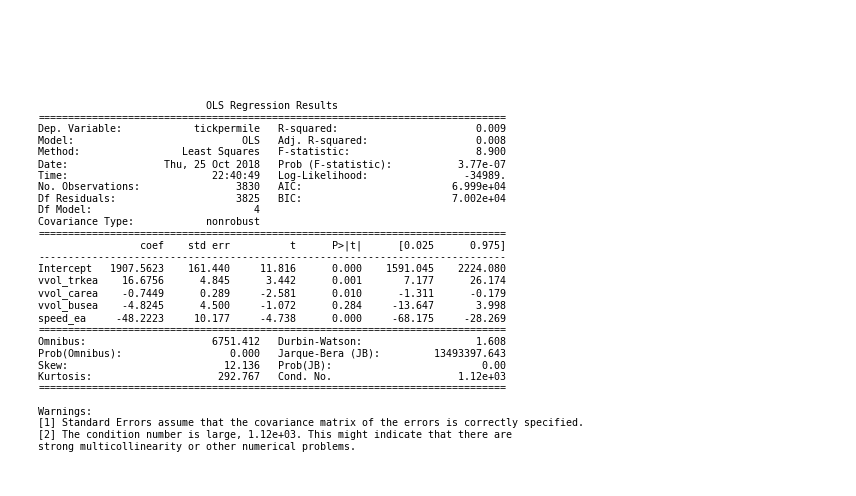

In [34]:
import statsmodels.api as sm
columns = ['vvol_trkea', 'vvol_carea', 'vvol_busea', 'speed_ea']

model = sm.OLS.from_formula('tickpermile ~' + '+'.join(columns) , streets)
res = model.fit()
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace') 
plt.axis('off')
plt.tight_layout()
plt.show()


The R squared volume is extremely low, showing there is clearly a lot this model is missing. However, the coefficients look to be somewhat strong. Looks as though bus volume and speed seem to have more of an effect than trucks or cars. Let's use the fitted values to set our index, and re-do our central limit theorem exercise and see if the population differences are measurable. 

In [35]:
streets['fitted'] =  res.fittedvalues
streets.sort_values(by = 'fitted', inplace = True)

Text(0.5, 0, 'Tickets per mile per year')

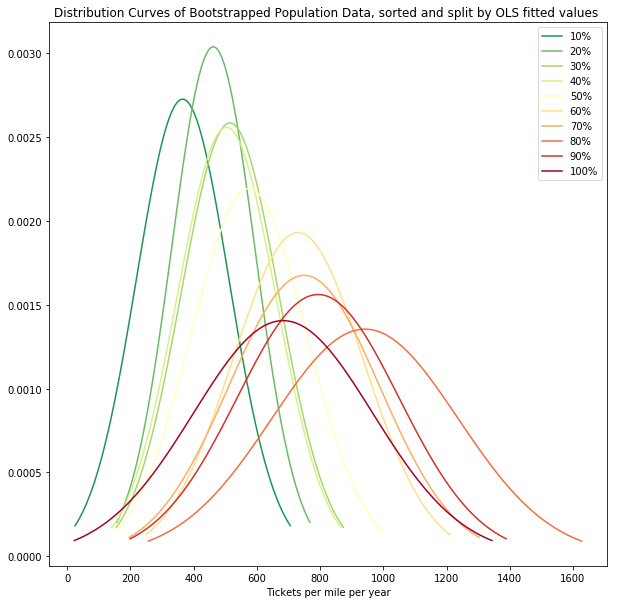

In [36]:
plt.figure(figsize = (10, 10))
means = {}
stds = {}
for i in np.arange(1,11):
    if i == 1:
        df = streets[0:int(totalsize * .1)]
    else:
        df = streets[((i-1)/10 * totalsize).astype(int): (((i)/10) * totalsize).astype(int)]
        
    sample = []
    for j in np.arange(1,1000):
        sample.append(df['tickpermile'].sample(n = 20).median())
        
    sample = np.array(sample)
        
    means[i] = sample.mean()
    stds[i] = sample.std()
    normals = norm(loc = means[i], scale = stds[i])
    
    x = np.linspace(normals.ppf(0.01), 
                        normals.ppf(0.99), 
                        100)
    labelstr = str(i * 10) + '%'
    plt.plot(x, normals.pdf(x), label = labelstr, color =  plt.cm.RdYlGn(1-(i/10)))
plt.legend( loc = 0)
plt.title('Distribution Curves of Bootstrapped Population Data, sorted and split by OLS fitted values ')
plt.xlabel('Tickets per mile per year')

In [37]:
means[1] / means[10]

0.534647941788394

This model would suggest the difference between the top and lowest population groups could reduce the amount of tickets by up to 50%. 

The Higher our variables get, the fit seems to be stronger, which would confirm that using these measure may be an accurate way to estimate ticket probability. Let's check out some diagnostic plots to confirm this. 

In [38]:
model_fit = res
# fitted 
model_fitted_y = model_fit.fittedvalues

# residuals
model_residuals = model_fit.resid

# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag


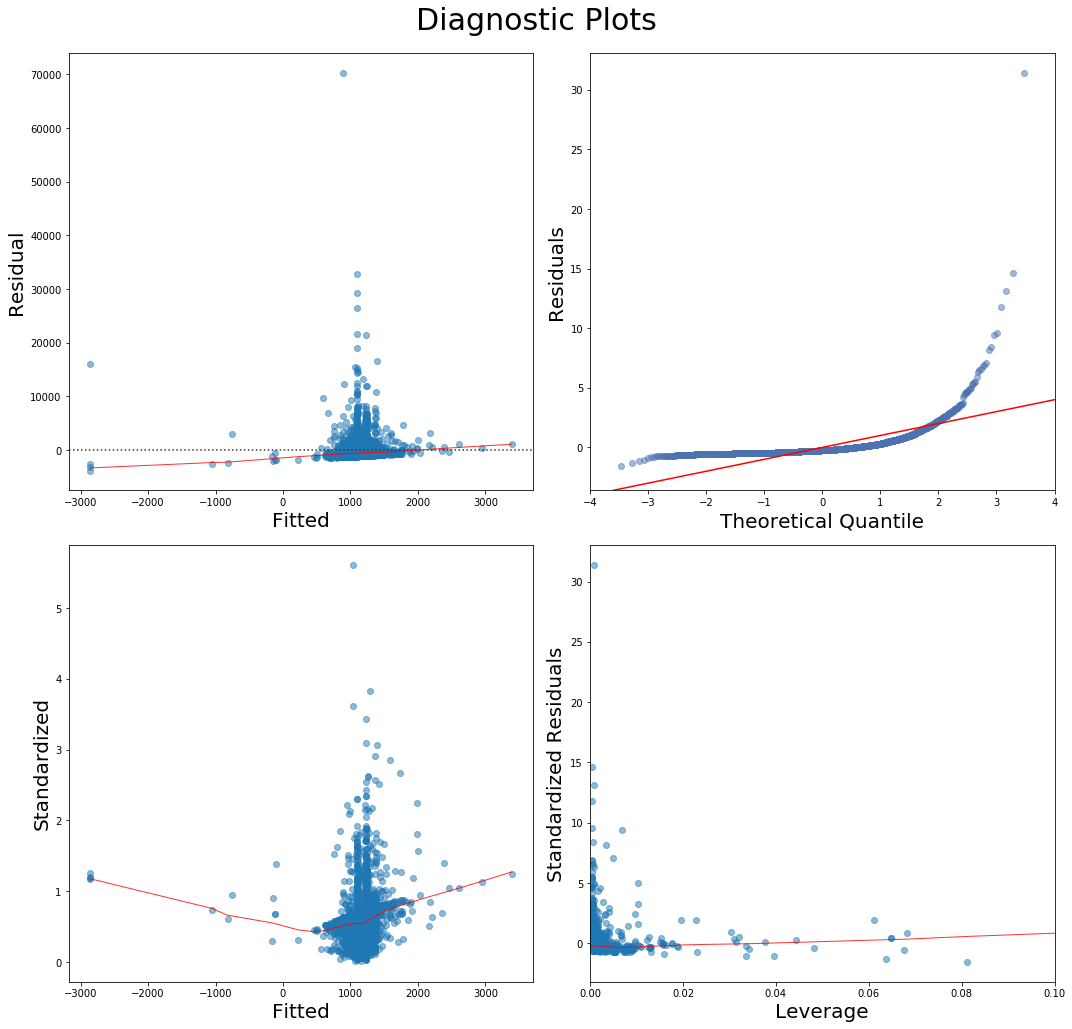

In [39]:
from statsmodels.graphics.gofplots import ProbPlot
#All four diagnostic plots in one place
fig, axarr = plt.subplots(2,2, figsize = (15,15))
fig.suptitle('Diagnostic Plots for OLS Model')
QQ = ProbPlot(model_norm_residuals)
plt.suptitle('Diagnostic Plots',  fontsize = 30)

#residuals 
sns.residplot( model_fitted_y, 'tickpermile', data=streets, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax = axarr[0,0])
axarr[0,0].set_xlabel('Fitted', fontsize = 20)
axarr[0,0].set_ylabel('Residual', fontsize = 20)


#Q-Q
QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1, ax = axarr[0,1])
axarr[0,1].set_xlabel('Theoretical Quantile', fontsize = 20)
axarr[0,1].set_ylabel('Residuals', fontsize = 20)
axarr[0,1].set_xlim(-4,4)



#scale - location
axarr[1,0].scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax = axarr[1,0])
axarr[1,0].set_xlabel('Fitted', fontsize = 20)
axarr[1,0].set_ylabel('Standardized', fontsize = 20)


#Leverage
axarr[1,1].scatter(model_leverage, model_norm_residuals, alpha=0.5)
sns.regplot(model_leverage, model_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax = axarr[1,1])
axarr[1,1].set_xlim(0,0.1)
axarr[1,1].set_xlabel('Leverage', fontsize = 20)
axarr[1,1].set_ylabel('Standardized Residuals', fontsize = 20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

The Q-Q Plot indicates there may be a non-linear relationship here. Let's try a few other fits. 

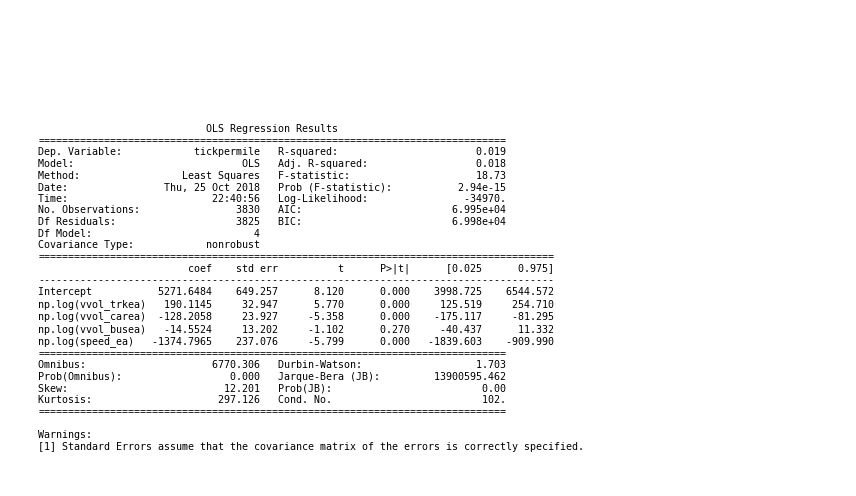

In [40]:
df = streets
for column in columns:
    df[column] = df[column] + 0.01
    
formstring = 'tickpermile ~np.log(vvol_trkea)+np.log(vvol_carea)+np.log(vvol_busea)+np.log(speed_ea)'
model = sm.OLS.from_formula(formstring , streets)
res = model.fit()
res.summary()
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace') 
plt.axis('off')
plt.tight_layout()
plt.show()


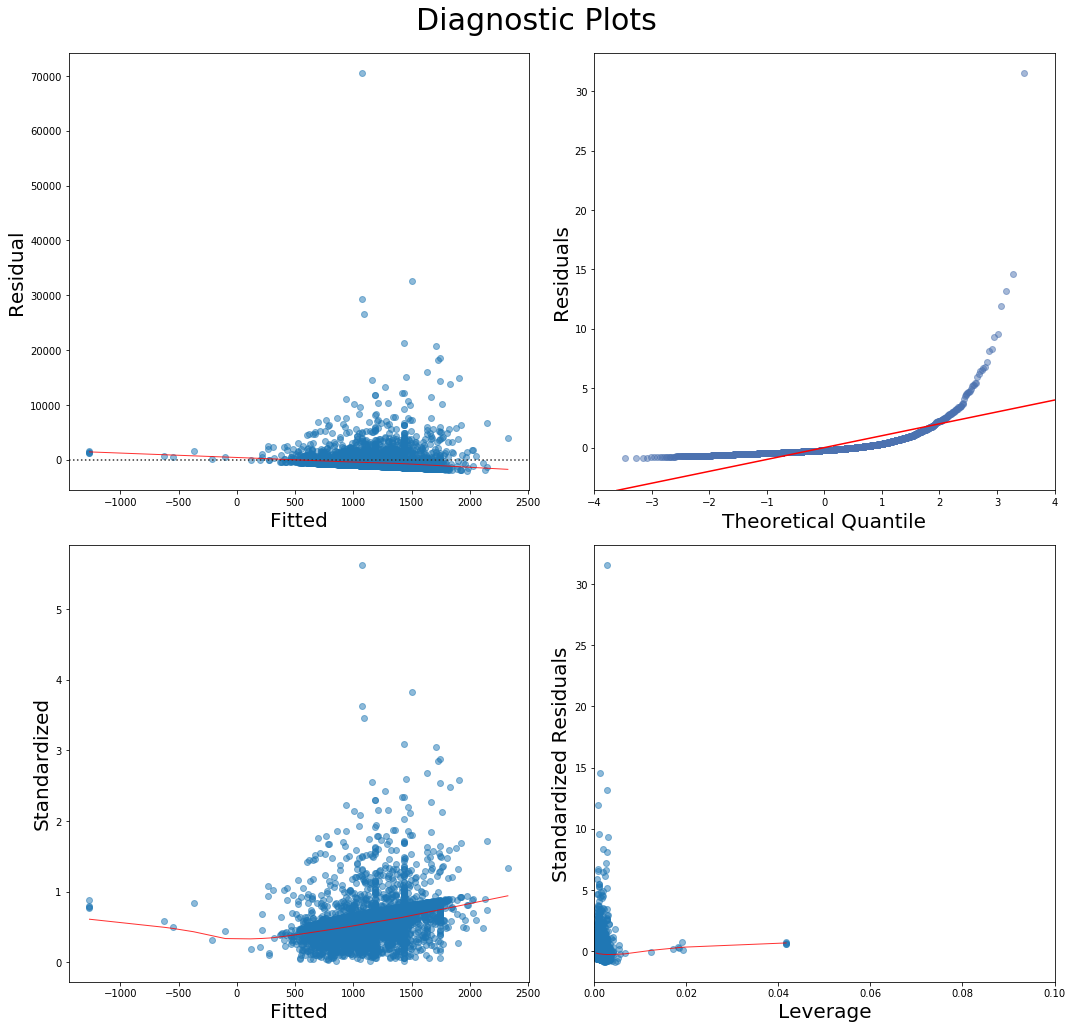

In [41]:
# Log fit seems to be a little better. 
model_fit = res
# fitted 
model_fitted_y = model_fit.fittedvalues

# residuals
model_residuals = model_fit.resid

# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
from statsmodels.graphics.gofplots import ProbPlot
#All four diagnostic plots in one place
fig, axarr = plt.subplots(2,2, figsize = (15,15))
fig.suptitle('Diagnostic Plots for OLS Model')
QQ = ProbPlot(model_norm_residuals)
plt.suptitle('Diagnostic Plots',  fontsize = 30)

#residuals 
sns.residplot( model_fitted_y, 'tickpermile', data=streets, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax = axarr[0,0])
axarr[0,0].set_xlabel('Fitted', fontsize = 20)
axarr[0,0].set_ylabel('Residual', fontsize = 20)


#Q-Q
QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1, ax = axarr[0,1])
axarr[0,1].set_xlabel('Theoretical Quantile', fontsize = 20)
axarr[0,1].set_ylabel('Residuals', fontsize = 20)
axarr[0,1].set_xlim(-4,4)



#scale - location
axarr[1,0].scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax = axarr[1,0])
axarr[1,0].set_xlabel('Fitted', fontsize = 20)
axarr[1,0].set_ylabel('Standardized', fontsize = 20)


#Leverage
axarr[1,1].scatter(model_leverage, model_norm_residuals, alpha=0.5)
sns.regplot(model_leverage, model_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax = axarr[1,1])
axarr[1,1].set_xlim(0,0.1)
axarr[1,1].set_xlabel('Leverage', fontsize = 20)
axarr[1,1].set_ylabel('Standardized Residuals', fontsize = 20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

Text(0.5, 0, 'Tickets per mile per year')

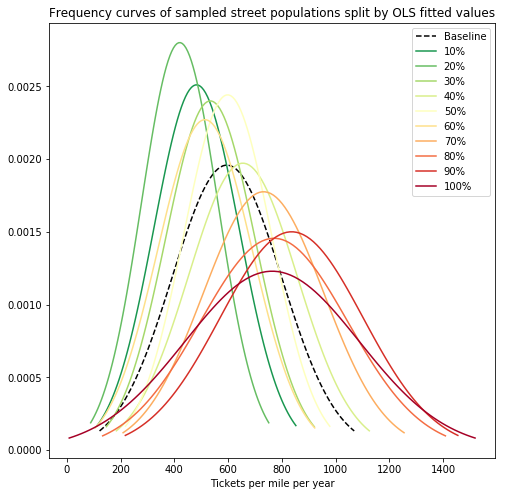

In [42]:
#Re-do our central limit exercise once again. 
streets['fitted'] =  res.fittedvalues
streets.sort_values(by = 'fitted', inplace = True)
plt.figure(figsize = (8, 8))
means = {}
stds = {}
df = streets
sample = []
boxdata = []
#create baseline curve
for j in np.arange(1,1000):
    sample.append(df['tickpermile'].sample(n = 20).median())
 

sample = np.array(sample)

means['base'] = sample.mean()
stds['base'] = sample.std()
normals = norm(loc = means['base'], scale = stds['base'])

x = np.linspace(normals.ppf(0.01), 
                    normals.ppf(0.99), 
                    100)
labelstr = str(i * 10) + '%'
plt.plot(x, normals.pdf(x), label = 'Baseline', color = 'black', linestyle = '--')

for i in np.arange(1,11):
    if i == 1:
        df = streets[0:int(totalsize * .1)]
    else:
        df = streets[((i-1)/10 * totalsize).astype(int): (((i)/10) * totalsize).astype(int)]

    sample = []
    boxdata.append(df['tickpermile'])
    for j in np.arange(1,1000):
        sample.append(df['tickpermile'].sample(n = 20).median())
        
    sample = np.array(sample)
        
    means[i] = sample.mean()
    stds[i] = sample.std()
    normals = norm(loc = means[i], scale = stds[i])
    
    x = np.linspace(normals.ppf(0.01), 
                        normals.ppf(0.99), 
                        100)
    labelstr = str(i * 10) + '%'
    plt.plot(x, normals.pdf(x), label = labelstr, color =  plt.cm.RdYlGn(1-(i/10)))
plt.legend( loc = 0)
plt.title('Dsitribution curves of sampled street populations sorted split by OLS fitted values')
plt.xlabel('Tickets per mile per year')

''

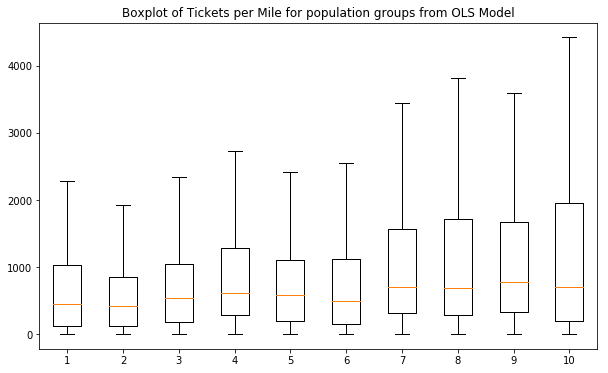

In [43]:
plt.figure(figsize = (10,6))
plt.boxplot(boxdata, showfliers = False)
plt.title('Boxplot of Tickets per Mile for population groups from OLS Model')
;


In [44]:
means[1] / means['base']

0.8102679835962044

In [45]:
means[1] / means[10]

0.6316122170319494

# Conclusion
Although there is a significant degree of uncertainty and variability, we can create a model that will estimate the amount of residential overtime tickets per street per year, and those results will be directionally accurate. If we assume that all other factors are equal. We can reduce the amount of tickets by up to 18% by strictly parking at locations that we identify in the top 10% rather than guessing normally, and up to 48% less than if we were to choose one of the worst set of streets. The most contributing factors are freeflow speed, car volume, and bus volume. 

However, this does not include parking spot availability. Note that bus volume is a much bigger factor than car volume. We know bus stops take up parking spots, so that is a clear correlation. I decided to run the whole analysis back, including parking availability data. You can find this in the next notebook. 
